# CS375 - Tutorial 1
### Welcome to tutorial 1! This tutorial will introduce you to basic MongoDB, Tensorflow, and tfutils functions and commands. We will learn how to setup a MongoDB database, and connect, read and write to it. We will then give you a brief refresher on Tensorflow, show you how to read data not only from feed dicts but also TFRecords and build a simple Multi-Layer Perceptron (MLP). We will also show you how to create TFRecord files out of your own data. Finally, we will show you how to use tfutils which puts all pieces together into one coherent framework.

## 1.) Using MongoDB with pymongo
### First we will learn how to use MongoDB. We will start with setting up a MongoDB database. We assume that you have installed MongoDB following any of the instructions that you can find online. A principled way to setup a MongoDB database is to use a config file. A mongodb.conf file needs to have the following content:

\# Where to store the data.  
dbpath=/mongodb/mongodb  
\# Where to log  
logpath=/mongodb/mongodb/mongodb.log  
\# IPs and ports your database is broadcasting to (127.0.0.1 is localhost).  
bind_ip = 127.0.0.1  
port = 24444

### That's it! That's all we need to setup and start a MongoDB database. If any of these is not defined MongoDB will fall back to its default settings. We can setup and start a MongoDB database with the following command:
`sudo mongod --config=mongodb.conf --quiet&`

### Now that we have setup our database, let's try to connect to it using the python interface "pymongo". Therefore, we need to specify the port and the host of the database we want to connect to:

In [1]:
import pymongo as pm
import numpy as np

port = 24444
host = 'localhost'
connection = pm.MongoClient(port = port, host = host)

### To test if we have successfully connected to our database let's print out the last 3 database names.

In [2]:
print(connection.database_names()[-4:])

[u'imagenet', u'local', u'mnist', u'mnist_simple_exp1___RECENT']


### Now let's say we are interested in the contents of "imagenet". As all Mongo data is returned in form of a dictionary we can access "future prediction" as follows and look up it's collections:

In [3]:
database = connection['imagenet']
print(database.collection_names())

[u'alexnet.files', u'alexnet.chunks']


### Let's dig deeper and have a look at "alexnet.files". As we have learned in the last lecture we have reached the level where we store our experiments uniquely identified by "exp_id". So let's find all unique "exp_id" in the "alexnet.files" collection.

In [4]:
collection = database['alexnet.files']
collection.distinct('exp_id')

[u'experiment_0', u'experiment_1', u'experiment_2']

### In order to find all entries with e. g. "experiment_1" we need to query the database for it's "exp_id". So we formulate a search query and use it to retrieve the entry as follows:

In [5]:
query = {'exp_id': 'experiment_1'}
entries = collection.find(query)
print(entries.count())

2760


### We have found 2760 entries with "exp_id" "experiment_1", some of which belong to training data, and some of which belong to validation data, which I know as I have created those entries with tfutils. Let's have a look at the contents of the first entry:

In [6]:
entries[0]

{u'_id': ObjectId('59cea1c51742f9204655a750'),
 u'duration': 49.862842082977295,
 u'exp_id': u'experiment_1',
 u'params': {u'dont_run': False,
  u'inter_op_parallelism_threads': 40,
  u'learning_rate_params': {u'boundaries': [150000, 300000, 450000],
   u'func': {u'active_branch': u'master',
    u'active_branch_in_origin': True,
    u'clean': False,
    u'commit': u'0b381e860e660586cf181ebdc7643d5c8bdbff22',
    u'commit_in_log': True,
    u'git_dir': u'/home/mrowca/workspace/cs375-private/.git',
    u'modname': u'__main__',
    u'objname': u'<lambda>',
    u'remote_urls': [u'https://github.com/neuroailab/cs375-private.git'],
    u'source_path': u'train_imagenet.py'},
   u'values': [0.01, 0.005, 0.001, 0.0005]},
  u'load_params': {u'collname': u'alexnet',
   u'dbname': u'imagenet',
   u'do_restore': False,
   u'exp_id': u'experiment_1',
   u'host': u'localhost',
   u'load_query': None,
   u'port': 24444},
  u'log_device_placement': False,
  u'loss_params': {u'agg_func': {u'modname': u'

### We see that the entry consists of a bunch of keys that store information about the trained model and training results. Now let's say we want to access only those entries that actually contain training results. In order to do this we have to formuate a new database query where we use the "$exists" keyword to signal that "train_results" has to exist in any entry that gets returned:

In [7]:
query_train = {'exp_id': 'experiment_1', 'train_results': {'$exists' : True}}
train_entries = collection.find(query_train)
train_entries[0]

{u'_id': ObjectId('59cea1c51742f9204655a750'),
 u'duration': 49.862842082977295,
 u'exp_id': u'experiment_1',
 u'params': {u'dont_run': False,
  u'inter_op_parallelism_threads': 40,
  u'learning_rate_params': {u'boundaries': [150000, 300000, 450000],
   u'func': {u'active_branch': u'master',
    u'active_branch_in_origin': True,
    u'clean': False,
    u'commit': u'0b381e860e660586cf181ebdc7643d5c8bdbff22',
    u'commit_in_log': True,
    u'git_dir': u'/home/mrowca/workspace/cs375-private/.git',
    u'modname': u'__main__',
    u'objname': u'<lambda>',
    u'remote_urls': [u'https://github.com/neuroailab/cs375-private.git'],
    u'source_path': u'train_imagenet.py'},
   u'values': [0.01, 0.005, 0.001, 0.0005]},
  u'load_params': {u'collname': u'alexnet',
   u'dbname': u'imagenet',
   u'do_restore': False,
   u'exp_id': u'experiment_1',
   u'host': u'localhost',
   u'load_query': None,
   u'port': 24444},
  u'log_device_placement': False,
  u'loss_params': {u'agg_func': {u'modname': u'

### Again, we obtain a list of entries out of which all contain "train_results".  We printed the content of the first returned entry and we can observe that although we requested only entries that contain "train_results" all of the entries data was returned and not only "train_results". If we want Mongo to return only "train_results" in each entry we have to use a projection as follows: 

In [8]:
train_entries = collection.find(query_train, projection = ['train_results'])
train_entries[0]

{u'_id': ObjectId('59cea1c51742f9204655a750'),
 u'train_results': [{u'learning_rate': 0.009999999776482582,
   u'loss': 6.9073381423950195},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.903197288513184},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.915280342102051},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.925808906555176},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.91734504699707},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.917638301849365},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.92468786239624},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.923411846160889},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.914703369140625},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.910067558288574},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.914397716522217},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.917898654937744},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.916857242584228

### As we can see we have now successfully retrieved "train_results" only, except for the unique identifier "_id" which always gets returned. These "train_results" entries were saved every couple of iterations while training a model in tfutils and for instance contain the training loss. Using this training data we can now easily construct a vector that contains the training loss over time by using a simple list comprehension:

In [9]:
train_entries = collection.find(query_train, projection = ['train_results'])
loss = np.array([results['loss'] for entry in train_entries for results in entry['train_results']])

### We can now go ahead and plot the loss:

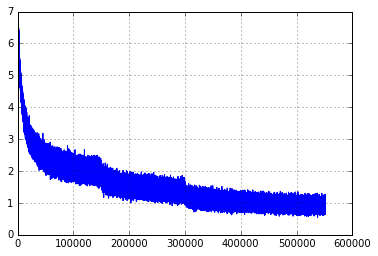

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.plot(loss)
plt.grid()

### Inserting records into MongoDB as easy as reading data from the database. You simply can simply use the "insert_one()" method as follows:

In [11]:
# entry has to be a dictionary
entry_1 = {'value': 10.1}
coll = connection['test_db']['test_coll']
coll.insert_one(entry_1)

### And if we now query the "test_coll" collection we can see that "entry_1" has been stored in the database:

In [12]:
coll = connection['test_db']['test_coll']
coll.find({'value': {'$exists' : True}})[0]

{u'_id': ObjectId('59dbff9a1742f972c1d896f2'), u'value': 10.1}

### Now let's insert two more entries and sort them by the "value" field:

In [13]:
entry_2 = {'value': 4.2}
entry_3 = {'value': 8.3}

coll = connection['test_db']['test_coll']
coll.insert_many([entry_2, entry_3])

entries = coll.find({'value': {'$exists' : True}}, projection=['value'])
entries = [entry for entry in entries]
print('Not sorted:')
for entry in entries:
    print(entry['value'])

entries = coll.find({'value': {'$exists' : True}}, projection=['value']).sort([('value',pm.ASCENDING)])
entries = [entry for entry in entries]
print('Sorted:')
for entry in entries:
    print(entry['value'])

Not sorted:
10.1
4.2
8.3
Sorted:
4.2
8.3
10.1


### Finally, let's clean up and delete some entries, the collection and database to conclude the tutorial on pymongo and MongoDB:

In [14]:
# remove entry with field 'value' = 10.1
#coll.remove({'value' : 10.1}, {'justOne': True})
coll.delete_one({'value' : 10.1})

# remove collection
connection['test_db'].drop_collection('test_coll')

# remove database
connection.drop_database('test_db')

## 2.) Creating a simple model in Tensorflow
### We will now move on to a brief exercise on Tensorflow. We will keep this section short since most of you should be familiar with Tensorflow by now. In the following, we will talk about how to create a Tensorflow graph, execute the graph in a session, variables and variable scopes, placeholders and feed dicts.

### First we will define a 3 layer MLP with 3 input neurons, 20 hidden neurons, and 3 output neurons in Tensorflow:

In [15]:
import tensorflow as tf
import numpy as np

# input placeholder
input_placeholder = tf.placeholder(tf.float32, shape=[None, 3])
# trainable variables randomly initialized
W1 = tf.Variable(tf.random_normal(shape=[3,20]), tf.float32)
b1 = tf.Variable(tf.random_normal(shape=[20,]), tf.float32)
W2 = tf.Variable(tf.random_normal(shape=[20,3]), tf.float32)
b2 = tf.Variable(tf.random_normal(shape=[3,]), tf.float32)
# hidden layer
h = tf.nn.sigmoid(tf.matmul(input_placeholder, W1) + b1)
# output
out = tf.matmul(h, W2) + b2

### To run one forward pass of this randomly initialized MLP with some random data we first have to create a session and initialize all variables:

In [16]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
# creates a session and allocates memory on GPU 2
sess = tf.Session()
# initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

### Then we can execute the forward pass with a call to the session's "run()" method, while specifying the output targets and feeding the input data through the feed_dict parameter to the placeholders:

In [17]:
# create some random input and run forward pass on it
inp = np.random.rand(1, 3).astype(np.float32)
result = sess.run(out, feed_dict={input_placeholder: inp})
print(result)

[[-1.51481223  2.80489588 -3.8322587 ]]
